# Day 2: Vanishing Gradient Problem

## Learning Objectives
- Understand why vanilla RNNs fail on long sequences
- Visualize gradient flow through time
- Learn solutions: gradient clipping, skip connections

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries loaded!")
print("📚 Day 2: Vanishing Gradient Problem")

✅ Libraries loaded!
📚 Day 2: Vanishing Gradient Problem


## Part 1: Mathematical Analysis

During BPTT:
$$\frac{\partial L}{\partial h_0} = \frac{\partial L}{\partial h_T} \cdot \prod_{t=1}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

Each term: $\frac{\partial h_t}{\partial h_{t-1}} = W_{hh}^T \cdot \text{diag}(1 - h_t^2)$

If $\|W_{hh}\| < 1$, gradients shrink exponentially!

GRADIENT FLOW ANALYSIS


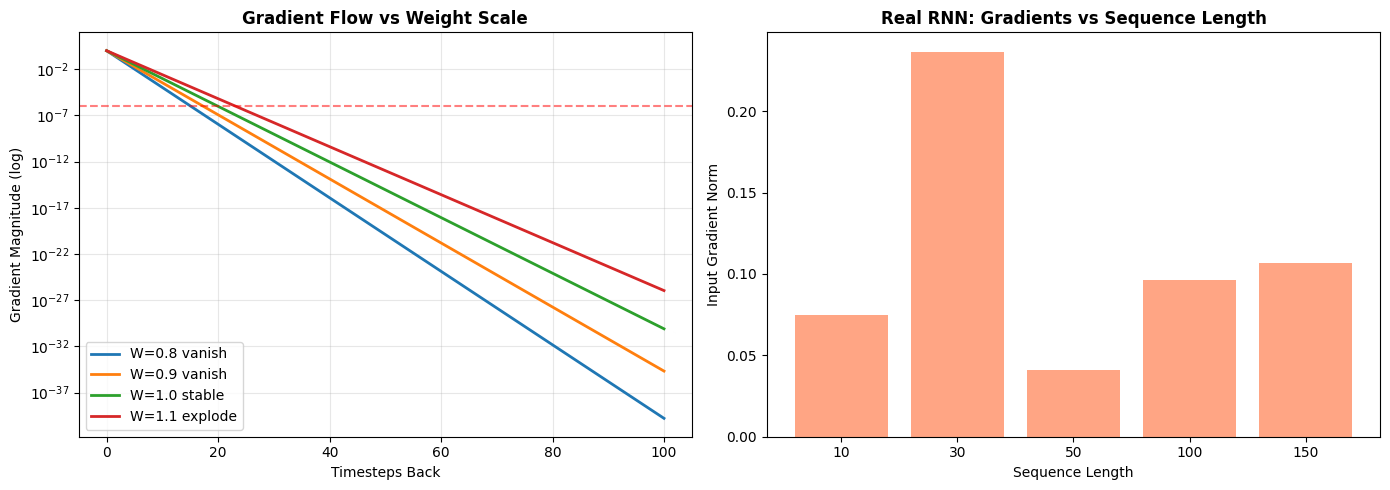


💡 Gradients vanish exponentially with sequence length!


In [2]:
# ============================================================
# VISUALIZING GRADIENT FLOW
# ============================================================

print("GRADIENT FLOW ANALYSIS")
print("="*60)

def simulate_gradient_flow(seq_length, weight_scale=0.9):
    """Simulate gradient magnitude over timesteps."""
    gradient = 1.0
    gradients = [gradient]
    
    for t in range(seq_length):
        # gradient *= W_hh * tanh'(h), where tanh' ≈ 0.5 on average
        gradient *= weight_scale * 0.5
        gradients.append(gradient)
    
    return np.array(gradients)

# Compare weight scales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ws in [0.8, 0.9, 1.0, 1.1]:
    grads = simulate_gradient_flow(100, ws)
    label = f'W={ws}' + (' vanish' if ws < 1 else ' explode' if ws > 1 else ' stable')
    axes[0].semilogy(grads, label=label, linewidth=2)

axes[0].axhline(1e-6, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Timesteps Back')
axes[0].set_ylabel('Gradient Magnitude (log)')
axes[0].set_title('Gradient Flow vs Weight Scale', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Real RNN gradient tracking
class GradientTracker(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.rnn = nn.RNN(5, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

gradient_norms = {}
for seq_len in [10, 30, 50, 100, 150]:
    model = GradientTracker()
    x = torch.randn(1, seq_len, 5, requires_grad=True)
    y = torch.randn(1, 1)
    
    loss = (model(x) - y).pow(2).mean()
    loss.backward()
    
    gradient_norms[seq_len] = x.grad.norm().item()

axes[1].bar([str(k) for k in gradient_norms.keys()], 
            list(gradient_norms.values()), color='coral', alpha=0.7)
axes[1].set_xlabel('Sequence Length')
axes[1].set_ylabel('Input Gradient Norm')
axes[1].set_title('Real RNN: Gradients vs Sequence Length', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Gradients vanish exponentially with sequence length!")

## Part 2: Long-Range Dependency Task

COPY TASK (LONG-RANGE DEPENDENCY)
  Delay   5: Accuracy = 99.8%
  Delay  20: Accuracy = 16.6%
  Delay  50: Accuracy = 9.6%
  Delay 100: Accuracy = 19.0%


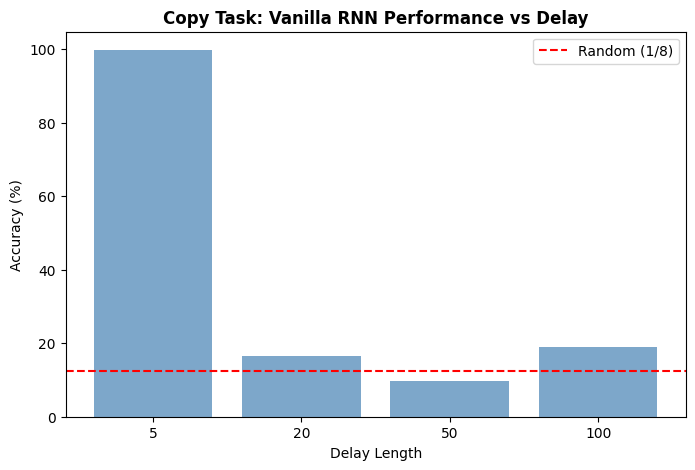


💡 RNN completely fails on longer delays - can't remember!


In [3]:
# ============================================================
# COPY TASK: DEMONSTRATING THE PROBLEM
# ============================================================

print("COPY TASK (LONG-RANGE DEPENDENCY)")
print("="*60)

def generate_copy_task(batch_size, seq_len, delay=10):
    """
    Task: Remember a sequence and reproduce it after a delay.
    Tests long-range memory.
    """
    # Random input sequence
    signal = torch.randint(0, 8, (batch_size, seq_len))
    
    # Input: [signal] + [delay zeros] + [marker]
    x = torch.zeros(batch_size, seq_len + delay + 1, 10)
    for b in range(batch_size):
        for t in range(seq_len):
            x[b, t, signal[b, t]] = 1  # One-hot encode
    x[:, seq_len + delay, 9] = 1  # Marker at position 9
    
    # Target: reproduce the signal after seeing marker
    y = signal
    
    return x, y

# Test different delays
seq_len = 5
results = {}

for delay in [5, 20, 50, 100]:
    # Create model
    class CopyRNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.rnn = nn.RNN(10, 64, batch_first=True)
            self.fc = nn.Linear(64, 8)
            
        def forward(self, x):
            out, _ = self.rnn(x)
            # Output for last seq_len positions
            return self.fc(out[:, -seq_len:, :])
    
    model = CopyRNN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # Train briefly
    for epoch in range(200):
        x, y = generate_copy_task(32, seq_len, delay)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out.view(-1, 8), y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    # Evaluate
    x, y = generate_copy_task(100, seq_len, delay)
    with torch.no_grad():
        preds = model(x).argmax(dim=-1)
        acc = (preds == y).float().mean().item()
    
    results[delay] = acc
    print(f"  Delay {delay:3d}: Accuracy = {acc*100:.1f}%")

# Visualize
plt.figure(figsize=(8, 5))
plt.bar([str(d) for d in results.keys()], [v*100 for v in results.values()],
        color='steelblue', alpha=0.7)
plt.axhline(12.5, color='red', linestyle='--', label='Random (1/8)')
plt.xlabel('Delay Length')
plt.ylabel('Accuracy (%)')
plt.title('Copy Task: Vanilla RNN Performance vs Delay', fontweight='bold')
plt.legend()
plt.show()

print("\n💡 RNN completely fails on longer delays - can't remember!")

## Part 3: Solutions to Vanishing Gradients

In [4]:
# ============================================================
# SOLUTION 1: GRADIENT CLIPPING
# ============================================================

print("GRADIENT CLIPPING")
print("="*60)

# Without clipping - exploding gradients
model = GradientTracker()
x = torch.randn(1, 100, 5, requires_grad=True)
y = torch.randn(1, 1) * 10  # Large target

loss = (model(x) - y).pow(2).mean()
loss.backward()

total_norm_before = 0
for p in model.parameters():
    if p.grad is not None:
        total_norm_before += p.grad.data.norm(2).item() ** 2
total_norm_before = total_norm_before ** 0.5

print(f"Gradient norm BEFORE clipping: {total_norm_before:.2f}")

# Apply clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

total_norm_after = 0
for p in model.parameters():
    if p.grad is not None:
        total_norm_after += p.grad.data.norm(2).item() ** 2
total_norm_after = total_norm_after ** 0.5

print(f"Gradient norm AFTER clipping:  {total_norm_after:.2f}")
print(f"\n✅ Gradient clipping prevents explosion but doesn't help vanishing!")

GRADIENT CLIPPING
Gradient norm BEFORE clipping: 31.19
Gradient norm AFTER clipping:  1.00

✅ Gradient clipping prevents explosion but doesn't help vanishing!


In [5]:
# ============================================================
# SOLUTION 2: SKIP CONNECTIONS (PREVIEW OF LSTM IDEA)
# ============================================================

print("\nSKIP CONNECTIONS")
print("="*60)

class RNNWithSkip(nn.Module):
    """RNN with additive skip connection."""
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.W_xh = nn.Linear(input_size, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h = torch.zeros(batch_size, self.hidden_size)
        
        for t in range(seq_len):
            new_h = torch.tanh(self.W_xh(x[:, t, :]) + self.W_hh(h))
            h = h + new_h  # SKIP CONNECTION (additive)
        
        return self.fc(h)

# Compare gradient flow
for model_name, model_class in [('Standard RNN', GradientTracker), 
                                  ('RNN + Skip', lambda: RNNWithSkip(5, 32))]:
    model = model_class()
    x = torch.randn(1, 100, 5, requires_grad=True)
    loss = model(x).pow(2).mean()
    loss.backward()
    
    print(f"{model_name}: Input gradient norm = {x.grad.norm().item():.6f}")

print("\n💡 Skip connections allow gradient to flow directly → LSTM/GRU principle!")


SKIP CONNECTIONS
Standard RNN: Input gradient norm = 0.052950
RNN + Skip: Input gradient norm = 371.858185

💡 Skip connections allow gradient to flow directly → LSTM/GRU principle!


In [6]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║           DAY 2 COMPLETE: VANISHING GRADIENTS                    ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Mathematical analysis of gradient flow                       ║
║  ✓ Demonstrated failure on long-range tasks                     ║
║  ✓ Gradient clipping (prevents explosion)                       ║
║  ✓ Skip connections (enables flow)                              ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 3 - LSTM Networks (the real solution!)
""")


╔══════════════════════════════════════════════════════════════════╗
║           DAY 2 COMPLETE: VANISHING GRADIENTS                    ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Mathematical analysis of gradient flow                       ║
║  ✓ Demonstrated failure on long-range tasks                     ║
║  ✓ Gradient clipping (prevents explosion)                       ║
║  ✓ Skip connections (enables flow)                              ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 3 - LSTM Networks (the real solution!)

